# EDA - Car Failure Analysis
### Problem Statement

- To analyse dataset and summarize the characteristics of each failure type.
- To gain insight into the different types of failure mechanisms.
- To predict the <u>occurrence of car failure</u> using the provided dataset from an automotive company to formulate mitigative policies.

### Required Libraries

In [1]:
from sqlalchemy import create_engine, MetaData, Table
import pandas as pd
import math
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import shapiro 
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#Allow wider display views of dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

### To connect with the database
To assess the database, SQLite (based on Python built-in module sqlite3) will be used to connect to the local file - failure.db, which is stored in a "data" folder.

As SQLite connects to local files, the URL format is slightly different. The “file” portion of the URL is the filename of the database. For a relative file path, this requires three slashes:

#### <u>Driver+Dialect</u>    Filename ----> <u>sqlite://</u>/Filename


Dataset from the following URL:
https://techassessment.blob.core.windows.net/aiap13-assessment-data/failure.db

In [2]:
engine = create_engine("sqlite:///C:/Users/krhen/Desktop/Work Documents/Jobs/AIAP13/data/failure.db")
print(engine.table_names())

['failure']


### Before querying the database, we will want to understand what is in it and what the tables are.

In [3]:
metadata = MetaData()
data_failure = Table('failure', metadata, autoload=True, autoload_with=engine)

In [4]:
print(repr(data_failure))

Table('failure', MetaData(), Column('Car ID', TEXT(), table=<failure>), Column('Model', TEXT(), table=<failure>), Column('Color', TEXT(), table=<failure>), Column('Temperature', TEXT(), table=<failure>), Column('RPM', INTEGER(), table=<failure>), Column('Factory', TEXT(), table=<failure>), Column('Usage', TEXT(), table=<failure>), Column('Fuel consumption', REAL(), table=<failure>), Column('Membership', TEXT(), table=<failure>), Column('Failure A', INTEGER(), table=<failure>), Column('Failure B', INTEGER(), table=<failure>), Column('Failure C', INTEGER(), table=<failure>), Column('Failure D', INTEGER(), table=<failure>), Column('Failure E', INTEGER(), table=<failure>), schema=None)


### Read table data using sql query and convert to dataframe.

In [5]:
sql = "SELECT * FROM failure"
dataframe = pd.read_sql(sql,con=engine)
df = dataframe
dataframe.to_csv('C:/Users/krhen/Desktop/Work Documents/Jobs/AIAP13/data/failure0.csv')

### Transform and process dataset
To remove duplicates, impute missing values, standardise data and create more significant features.

We first check if there is any presence of missing value.

In [6]:
df_process1 = df[df.isna().any(axis=1)]
df_process1.head(10)

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
18,d81f4614-cbe0-4e75-a927-e034f390062e,"Model 7, 2020",Black,110.6 °C,1306,"Seng Kang, China",High,892.9,None,0,0,1,0,0
30,a2f247b5-c1d5-48de-9c7f-8c5c3028415e,"Model 5, 2018",Red,231.2 °F,1339,"New York, U.S",High,677.7,None,0,0,0,1,0
105,27b1aeb4-f55a-4318-a325-7986a2ca9663,"Model 3, 2019",White,110.6 °C,1591,"Shang Hai, China",High,659.6,None,0,1,0,0,0
163,d0b8eee0-3644-4931-9351-370bdae1e20f,"Model 5, 2022",White,110.4 °C,1468,"Berlin, Germany",Low,734.2,None,0,0,0,1,0
168,6fecb493-797b-4e5f-82b2-7fa16d3309b9,"Model 3, 2021",White,110.4 °C,1433,"Shang Hai, China",High,605.9,None,0,0,0,0,1
194,d710a346-44b0-43c4-bc37-2959ac2771ab,"Model 5, 2018",Grey,110.4 °C,2678,"Shang Hai, China",Low,704.9,None,0,0,0,0,1
250,84209dd4-25b8-40da-95d2-1febc486c55a,"Model 3, 2022",Grey,110.3 °C,1662,"Shang Hai, China",High,710.7,None,0,0,0,1,0
259,4684474e-fbdc-4007-9b91-84805eeb40f4,"Model 5, 2021",Red,110.3 °C,1420,"Shang Hai, China",High,658.5,None,0,0,0,0,1
265,15f22aac-76e1-43d4-b239-141f0a7cf405,"Model 3, 2020",White,230.6 °F,1454,"Newton, China",Medium,651.5,None,0,0,0,1,0
271,8c9ae812-33de-4c8c-aa15-9dd699997a01,"Model 5, 2019",White,110.3 °C,1452,"Shang Hai, China",High,769.9,None,0,0,0,0,1


It seems that Attribute 'Membership' has 'NaN' values.

In [7]:
print('Total number of data points with missing values:', df_process1.shape[0])
print('Percentage missing values with respect to total dataset: {0:.2f}%'.format(50*df_process1.shape[0]/df.shape[0]))

Total number of data points with missing values: 384
Percentage missing values with respect to total dataset: 1.90%


Cars with 'NaN' Memberships have failure occurence close to that of cars with 'None' Memberships across each failure type.

In [8]:
#Sum of each failure type for cars with 'NaN' membership
df_process1 = df_process1[['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']].sum()
display(df_process1)

#Sum of each failure type for each category of membership
df_process2 = df.groupby('Membership')[['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']].sum()
display(df_process2)

Failure A     59
Failure B     60
Failure C    104
Failure D     69
Failure E     92
dtype: int64

,Failure A,Failure B,Failure C,Failure D,Failure E
Membership,,,,,
None,118,58,96,90,97
Normal,37,27,53,43,43
Premium,45,42,60,45,34


Since Membership is a categorical feature and missing data points only constitute 1.9% of total dataset, cells with 'NaN' values will be replaced with the most frequency category 'None'.

In [9]:
#standardise the temperature attribute in the dataset and convert Fahrenheit to Celsius
df['Temperature'] = df['Temperature'].replace(to_replace=['\u00b0', 'C'], value='', regex=True)
df['Temperature'] = df['Temperature'].replace(to_replace=['\u00b0', 'F'], value='', regex=True)
df['Temperature'] = df['Temperature'].astype(float)
df.loc[df['Factory'] == 'New York, U.S', 'Temperature'] = (df['Temperature']-32)*5/9
df.loc[df['Factory'] == 'Newton, China', 'Temperature'] = (df['Temperature']-32)*5/9

#standardise the RPM attribute in the dataset to be positive
df.loc[df['RPM'] < 0, 'RPM'] = df['RPM']*-1

#replace 'NaN' membership entry as None
df.fillna('None', inplace=True)

#Split the Model attribute into Model and Year Produced.
df[['Model', 'Year']] = df["Model"].apply(lambda x: pd.Series(str(x).split(",")))
df['Year'] = df['Year'].astype(int)

#Remove duplicates of cars with same unique ID
boolean_series = df.duplicated(keep='first')
print('Number of duplicates to be removed:', df[boolean_series]['Car ID'].nunique())
df.drop_duplicates(keep='first', inplace=True)

# Condition of the car - 0 = No Failure Found/ 1 = Failed
df['Condition'] = df['Failure A'] + df['Failure B'] + df['Failure C'] + df['Failure D'] + df['Failure E']
#Current number of rows in dataframe
print('Current number of rows in dataframe:', df.shape[0])
print('Current number of columns in dataframe:', df.shape[1])

Number of duplicates to be removed: 81
Current number of rows in dataframe: 10000
Current number of columns in dataframe: 16


### Encoding for categorical attributes

In [10]:
lbl = LabelEncoder()
# Model - Model 3=1/ Model 5=2/ Model 7=3
df['Model_'] = lbl.fit_transform(df['Model'])

# Color - Black=1/ Blue=2/ Grey=3/ Red=4/ White=5
df['Color_'] = lbl.fit_transform(df['Color'])

# Factory - Bedok, Germany=0/ Berlin, Germany=1/ New York, U.S=2/ Newton, China=4/ Seng Kang, China=5/ Shang Hai, China=5
df['Factory_'] = lbl.fit_transform(df['Factory'])

# Usage - High=0/ Low=1/ Medium=2
df['Usage_'] = lbl.fit_transform(df['Usage'])

# Membership - None=0/ Normal=1/ Premium=2
df['Membership_'] = lbl.fit_transform(df['Membership'])

In [11]:
df.to_csv('C:/Users/krhen/Desktop/Work Documents/Jobs/AIAP13/data/failure.csv')
df.head(10)

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year,Condition,Model_,Color_,Factory_,Usage_,Membership_
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.300000,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022,0,1,1,5,2,1
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,Black,110.400000,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,2022,1,0,0,5,2,2
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,Grey,110.300000,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,2022,0,0,2,5,1,2
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,Black,110.400000,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,2022,1,0,0,1,0,2
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,White,110.388889,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,2022,1,0,4,2,0,1
5,3b5e4310-9f3f-4c4d-92c3-ec09fa36f772,Model 5,White,110.300000,1425,"Shang Hai, China",Medium,691.8,Premium,0,0,0,0,0,2021,0,1,4,5,2,2
6,6758d615-185a-4ad3-b9a5-d5b4ebf9e933,Model 3,White,110.300000,1558,"Shang Hai, China",Medium,660.1,Premium,0,0,0,0,0,2021,0,0,4,5,2,2
7,ee7d677a-8f65-4773-a158-e59843ae8109,Model 3,White,110.300000,1527,"Berlin, Germany",Medium,673.0,Premium,0,0,0,0,0,2021,0,0,4,1,2,2
8,bcac8a8b-fb2c-43d9-aa80-193421f70e36,Model 5,Red,110.400000,1667,"Shang Hai, China",Medium,655.6,Normal,0,0,0,0,0,2021,0,1,3,5,2,1
9,fef5d386-9636-4a63-8a39-67bd005be989,Model 5,Black,110.400000,1741,"Berlin, Germany",Medium,648.9,Normal,0,0,0,0,0,2021,0,1,0,1,2,1


## Exploratory Data Analysis

Let's look at some basic descriptive statistics.

## Observation 1 - Based on Figure 1 and Figure 2

Total number of cars with failure = 1262
Total number of cars without failure = 8738


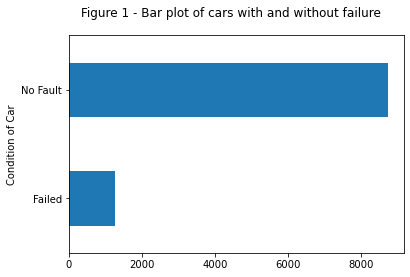

In [12]:
#Number of cars with failures
Num_of_failed = df[df['Condition']==1]['Car ID'].count()
print('Total number of cars with failure =', Num_of_failed)

#Number of cars without failures
Num_of_passed = df[df['Condition']==0]['Car ID'].count()
print('Total number of cars without failure =', Num_of_passed)

df_1 = pd.DataFrame({'Condition of Car':['Failed', 'No Fault'], 'Number of Cars':[Num_of_failed, Num_of_passed]})
ax = df_1.plot.barh(x='Condition of Car', y='Number of Cars', rot=0, legend=None)
plt.suptitle('Figure 1 - Bar plot of cars with and without failure')
plt.show()

Total number of cars with Failure A = 259
Total number of cars with Failure B = 185
Total number of cars with Failure C = 310
Total number of cars with Failure D = 244
Total number of cars with Failure E = 264


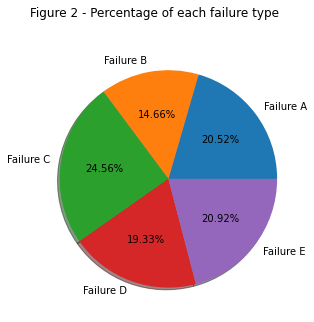

In [13]:
#Number of failures of each type
Num_of_failA = df[df['Failure A']==1]['Car ID'].count()
Num_of_failB = df[df['Failure B']==1]['Car ID'].count()
Num_of_failC = df[df['Failure C']==1]['Car ID'].count()
Num_of_failD = df[df['Failure D']==1]['Car ID'].count()
Num_of_failE = df[df['Failure E']==1]['Car ID'].count()
print('Total number of cars with Failure A =', Num_of_failA)
print('Total number of cars with Failure B =', Num_of_failB)
print('Total number of cars with Failure C =', Num_of_failC)
print('Total number of cars with Failure D =', Num_of_failD)
print('Total number of cars with Failure E =', Num_of_failE)

df_fail = pd.DataFrame({'Percentage of Failure': [Num_of_failA, Num_of_failB, Num_of_failC, Num_of_failD, Num_of_failE]},
                  index=['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E'])
 
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=1)
fig.subplots_adjust(top=0.88)
df_fail.plot.pie(y='Percentage of Failure', ax = axs, autopct='%.2f%%', shadow=True, ylabel='',legend=None)

plt.suptitle('Figure 2 - Percentage of each failure type')
plt.show()

### Possible Insight:

Most cars suffer from Type A, C, D and E failures. 

## Distribution of Dataset

The distribution of dataset is found to be not normally distributed. There are more cases of car without failure as compared to cases with failure. 

We have to randomly select non-failure cases to form a more unbiased dataset. On average, there is 1262 cases of failure. Hence we will randonly select 1262 cases from non-failure labels.

In [14]:
#Randomly picked 'Num_of_failed' samples out of non-failure samples
df_0 = df[df['Condition']==0]
df_0 = df_0.sample(n=Num_of_failed, random_state=0)

#remove the rows with Condition == 0
df.drop(df[df.Condition == 0].index, inplace=True)
df = pd.concat([df_0, df], axis=0) #combine both datasets according to columns names

# shuffle the DataFrame rows
df = df.sample(frac = 1, random_state=0) #random shuffle the whole dataset
display(df)

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year,Condition,Model_,Color_,Factory_,Usage_,Membership_
8028,e001eca8-1faf-4b1b-b883-944b990dd64f,Model 3,Red,111.900000,1501,"Shang Hai, China",High,639.3,None,0,0,0,1,0,2011,1,0,3,5,0,0
2728,4a1061cd-350f-4a02-9966-0b772151095d,Model 3,Grey,111.000000,1779,"Berlin, Germany",Low,643.7,None,0,0,1,0,0,2016,1,0,2,1,1,0
1245,f1accb6d-58d5-4b2c-94ca-d45093a6aa19,Model 5,White,110.200000,1588,"Shang Hai, China",Medium,713.6,Normal,0,0,0,0,0,2012,0,1,4,5,2,1
8766,0fbf596b-4764-4f1a-bb22-e2dacc014270,Model 3,Black,110.200000,1360,"Shang Hai, China",Low,659.3,Premium,0,0,0,0,0,2012,0,0,0,5,1,2
545,54ad45ba-9fd5-4793-b7d4-7c56426570df,Model 3,Black,110.222222,1958,"New York, U.S",High,649.8,None,1,0,0,0,0,2017,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161,47d3ddc2-17e8-4a1e-905d-ce81a34be235,Model 5,White,131.700000,2028,"Shang Hai, China",High,696.7,Normal,0,0,0,0,0,2020,0,1,4,5,0,1
3854,133eff28-5076-42ca-8d37-527fcb34a046,Model 3,Blue,116.700000,1338,"Berlin, Germany",High,638.5,Normal,0,0,0,0,1,2012,1,0,1,1,0,1
7398,cf83c621-463f-4cc5-815b-74c819ddf790,Model 5,Black,111.000000,1498,"Shang Hai, China",High,733.5,None,0,0,0,0,0,2015,0,1,0,5,0,0
7079,589dd1b4-151e-4d71-9dcb-1b5da0fb1f37,Model 3,White,112.100000,1445,"Shang Hai, China",Low,618.0,Premium,0,0,0,0,0,2012,0,0,4,5,1,2


In [15]:
df.describe()

,Temperature,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Year,Condition,Model_,Color_,Factory_,Usage_,Membership_
count,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000,2524.000000
mean,113.421487,1536.641046,684.828487,0.102615,0.073296,0.122821,0.096672,0.104596,2016.461173,0.500000,0.476228,2.912441,3.389857,0.920761,0.849842
std,4.794657,210.421739,61.248019,0.303515,0.260674,0.328297,0.295569,0.306093,3.263509,0.500099,0.667332,1.432266,1.761928,0.855875,0.808224
min,110.055556,1181.000000,598.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.400000,1404.000000,640.700000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,111.500000,1494.000000,674.800000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,0.500000,0.000000,4.000000,5.000000,1.000000,1.000000
75%,114.111111,1612.000000,713.025000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.000000,1.000000,1.000000,4.000000,5.000000,2.000000,2.000000
max,136.800000,2886.000000,904.800000,1.000000,1.000000,1.000000,1.000000,1.000000,2022.000000,1.000000,2.000000,4.000000,5.000000,2.000000,2.000000


We now have 2524 cases of car conditions which is more evenly distributed.

## Observation 2 - Based on Figure 3 and 4

###  Plot Correlation Matrix to see the strength and direction of linear relationship between each variable.
<strong>Note</strong>: Low linear correlation coefficient only indicates no linearity of relationship between two variables. The hypothesis of nonlinear correlation might still be true.

To better understand the characteristics of each failure type, we can first look into the correlation between each car's attribute.

In [16]:
data0=df[['Condition','Model_','Year','Color_','Temperature','RPM','Factory_','Usage_','Fuel consumption','Membership_']]
data0.head(10)

,Condition,Model_,Year,Color_,Temperature,RPM,Factory_,Usage_,Fuel consumption,Membership_
8028,1,0,2011,3,111.900000,1501,5,0,639.3,0
2728,1,0,2016,2,111.000000,1779,1,1,643.7,0
1245,0,1,2012,4,110.200000,1588,5,2,713.6,1
8766,0,0,2012,0,110.200000,1360,5,1,659.3,2
545,1,0,2017,0,110.222222,1958,2,0,649.8,0
8058,1,0,2019,1,111.555556,1515,2,0,658.0,0
722,0,0,2015,4,110.222222,1427,2,2,679.3,1
9872,1,0,2017,4,110.600000,1373,5,0,720.4,0
3650,1,0,2017,4,115.400000,1446,5,1,610.3,0
63,1,1,2013,4,110.600000,1812,1,2,737.7,2


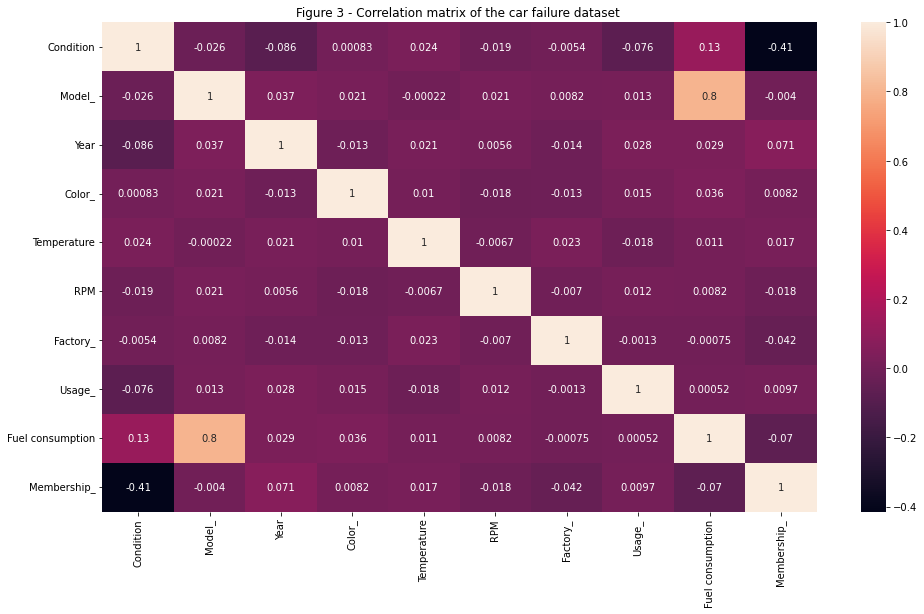

In [17]:
corr_matrix = data0.corr()

fig, ax = plt.subplots(figsize=(16,9)) 
sn.heatmap(corr_matrix, annot=True, ax=ax)

ax.set(title="Figure 3 - Correlation matrix of the car failure dataset ")
plt.show()

In [18]:
data1=df[['Failure A','Failure B','Failure C','Failure D','Failure E','Model_','Year','Color_','Temperature','RPM','Factory_','Usage_','Fuel consumption','Membership_']]
display(data1)

,Failure A,Failure B,Failure C,Failure D,Failure E,Model_,Year,Color_,Temperature,RPM,Factory_,Usage_,Fuel consumption,Membership_
8028,0,0,0,1,0,0,2011,3,111.900000,1501,5,0,639.3,0
2728,0,0,1,0,0,0,2016,2,111.000000,1779,1,1,643.7,0
1245,0,0,0,0,0,1,2012,4,110.200000,1588,5,2,713.6,1
8766,0,0,0,0,0,0,2012,0,110.200000,1360,5,1,659.3,2
545,1,0,0,0,0,0,2017,0,110.222222,1958,2,0,649.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161,0,0,0,0,0,1,2020,4,131.700000,2028,5,0,696.7,1
3854,0,0,0,0,1,0,2012,1,116.700000,1338,1,0,638.5,1
7398,0,0,0,0,0,1,2015,0,111.000000,1498,5,0,733.5,0
7079,0,0,0,0,0,0,2012,4,112.100000,1445,5,1,618.0,2


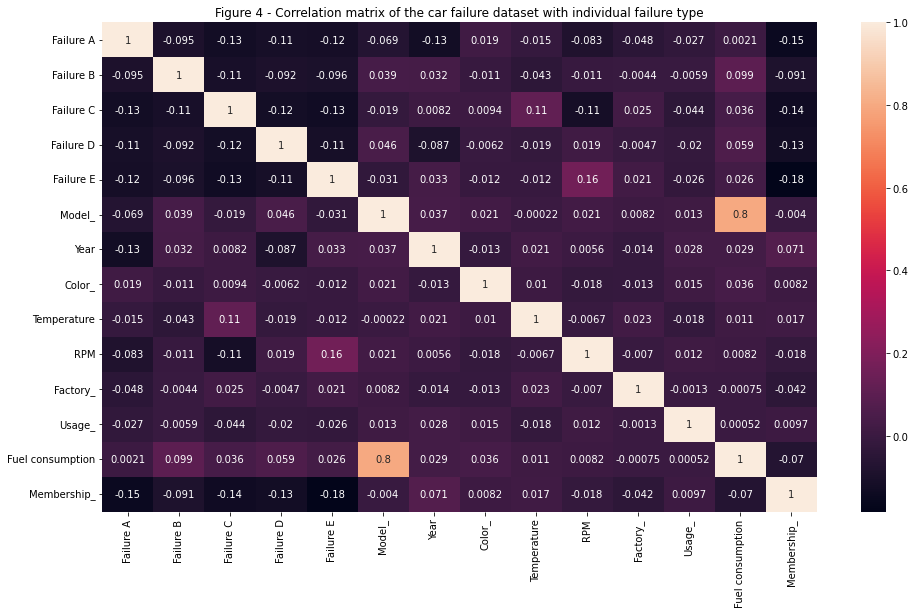

In [19]:
corr_matrix = data1.corr()

fig, ax = plt.subplots(figsize=(16,9)) 
sn.heatmap(corr_matrix, annot=True, ax=ax)

ax.set(title="Figure 4 - Correlation matrix of the car failure dataset with individual failure type")
plt.show()

### Possible Insights:
Figure 3 and 4 show the correlation matrices on heatmaps. We can derive the following insights from these correlation matrices:

- There is a highly negative correlation between failure occurence and membership - Cars without any membership tend to have failure. Failures might be due to lack of maintenance servicing.

- All types of failures (A to E) have negative correlation between membership status.

- Overall failure occurence is not linearly correlated to the color of car (lack of linear correlation doesn’t cross out the hypothesis of nonlinear correlation).

- Overall failure occurence has weak positive correlation with the fuel consumption of car.

- Failure A has slight negative correlation with the year of production. 

- Failure B has observable positive correlation with fuel consumption as compared to other failure types. This suggest that Failure B might be caused by engine issue such as faulty spark plugs, dirty fuel filters and air filters, faulty oxygen sensors, dirty fuel injectors or faulty engine valves which all lead to incomplete fuel combustion.

- Failure C has observable positive correlation with the temperature of car engine. It might be due to engine overheating issue due to cooling system leakage, faulty radiator fan, broken water pump, or clogged coolant hose.

- Failure A and C also show observable negative correlations with the RPM. This could be related to engine issue such as faulty or clogged idle air control valve which may lead to low torque speed produced.

- Failure E has slight positive correlation with RPM of car engine. It can be related to gearbox or brakes issue caused by overtorquing.

- Fuel consumption is highly and positively correlated with the model - Model 7 cars tend to have higher fuel consumptions.

- Factory/location of production does not seem to have correlation with each type of failure. This suggests that most failures are not caused by intrinsic production issues but rather caused by poor upkeep. 

## Observation 3 - Based on Figures 5 to 7

### Comparing number of failures between each model under different memberships,

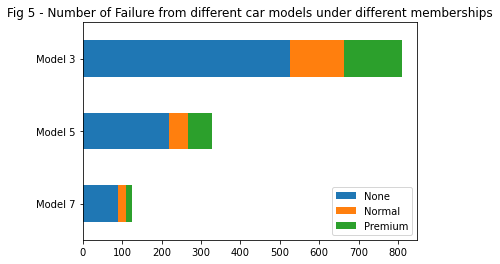

In [20]:
data2 = df[['Condition','Model','Membership','Car ID']]
data2 = data2.groupby(['Condition','Model','Membership'])[['Car ID']].count().reset_index()
data2 = data2[data2['Condition']==1].sort_values(by=['Car ID'], ascending = True)

index = list(data2['Model'].unique())
data2 = pd.DataFrame({'None': list(data2[data2['Membership']=='None']['Car ID']),
                     'Normal': list(data2[data2['Membership']=='Normal']['Car ID']),
                     'Premium': list(data2[data2['Membership']=='Premium']['Car ID'])},index=index)

ax = data2.plot.barh(stacked=True)
ax.set(title="Fig 5 - Number of Failure from different car models under different memberships")
plt.show()

#### Possible insight:
- Most of the failures are contributed by Car Model 3.
- Most failures come from cars without memberships. Since car owners are automatically subscribed with “Normal” membership for the first five years after car purchase, cars without memberships are likely those with lifespan more than 5 years and lack servicing. Lack of maintenance and long mileage might be the cause of most failures.

### Analyzing the distribution of each model based on each failure type,

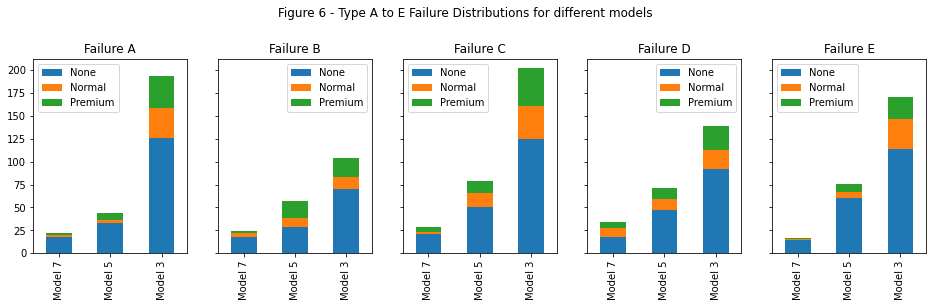

In [21]:
data3 = df[df['Failure A']==1]
data3 = data3[['Model','Membership','Car ID']]
data3 = data3.groupby(['Model','Membership'])[['Car ID']].count().reset_index()
data3 = data3.sort_values(by=['Car ID'], ascending = True)

index = list(data3['Model'].unique())
data3 = pd.DataFrame({'None': list(data3[data3['Membership']=='None']['Car ID']),
                      'Normal': list(data3[data3['Membership']=='Normal']['Car ID']),
                      'Premium': list(data3[data3['Membership']=='Premium']['Car ID'])},index=index)

data4 = df[df['Failure B']==1]
data4 = data4[['Model','Membership','Car ID']]
data4 = data4.groupby(['Model','Membership'])[['Car ID']].count().reset_index()
data4 = data4.sort_values(by=['Car ID'], ascending = True)

index = list(data4['Model'].unique())
data4 = pd.DataFrame({'None': list(data4[data4['Membership']=='None']['Car ID']),
                      'Normal': list(data4[data4['Membership']=='Normal']['Car ID']),
                      'Premium': list(data4[data4['Membership']=='Premium']['Car ID'])},index=index)

data5 = df[df['Failure C']==1]
data5 = data5[['Model','Membership','Car ID']]
data5 = data5.groupby(['Model','Membership'])[['Car ID']].count().reset_index()
data5 = data5.sort_values(by=['Car ID'], ascending = True)

index = list(data5['Model'].unique())
data5 = pd.DataFrame({'None': list(data5[data5['Membership']=='None']['Car ID']),
                      'Normal': list(data5[data5['Membership']=='Normal']['Car ID']),
                      'Premium': list(data5[data5['Membership']=='Premium']['Car ID'])},index=index)

data6 = df[df['Failure D']==1]
data6 = data6[['Model','Membership','Car ID']]
data6 = data6.groupby(['Model','Membership'])[['Car ID']].count().reset_index()
data6 = data6.sort_values(by=['Car ID'], ascending = True)

index = list(data6['Model'].unique())
data6 = pd.DataFrame({'None': list(data6[data6['Membership']=='None']['Car ID']),
                      'Normal': list(data6[data6['Membership']=='Normal']['Car ID']),
                      'Premium': list(data6[data6['Membership']=='Premium']['Car ID'])},index=index)

data7 = df[df['Failure E']==1]
data7 = data7[['Model','Membership','Car ID']]
data7 = data7.groupby(['Model','Membership'])[['Car ID']].count().reset_index()
data7 = data7.sort_values(by=['Car ID'], ascending = True)

index = list(data7['Model'].unique())
data7 = pd.DataFrame({'None': list(data7[data7['Membership']=='None']['Car ID']),
                      'Normal': list(data7[data7['Membership']=='Normal']['Car ID']),
                      'Premium': list(data7[data7['Membership']=='Premium']['Car ID'])},index=index)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=5, sharey='all')
data3.plot.bar(stacked=True, ax = axs[0])
data4.plot.bar(stacked=True, ax = axs[1])
data5.plot.bar(stacked=True, ax = axs[2])
data6.plot.bar(stacked=True, ax = axs[3])
data7.plot.bar(stacked=True, ax = axs[4])

axs[0].set_title('Failure A')
axs[1].set_title('Failure B')
axs[2].set_title('Failure C')
axs[3].set_title('Failure D')
axs[4].set_title('Failure E')
plt.suptitle('Figure 6 - Type A to E Failure Distributions for different models')
fig.subplots_adjust(top=0.8)
plt.show()

Percentage of Model 3 with Failure A = 15.29%
Percentage of Model 3 with Failure B = 8.24%
Percentage of Model 3 with Failure C = 16.01%
Percentage of Model 3 with Failure D = 11.01%
Percentage of Model 3 with Failure E = 13.55% 

Percentage of Model 5 with Failure A = 3.49%
Percentage of Model 5 with Failure B = 4.52%
Percentage of Model 5 with Failure C = 6.26%
Percentage of Model 5 with Failure D = 5.63%
Percentage of Model 5 with Failure E = 6.02% 

Percentage of Model 7 with Failure A = 1.74%
Percentage of Model 7 with Failure B = 1.90%
Percentage of Model 7 with Failure C = 2.30%
Percentage of Model 7 with Failure D = 2.69%
Percentage of Model 7 with Failure E = 1.35%


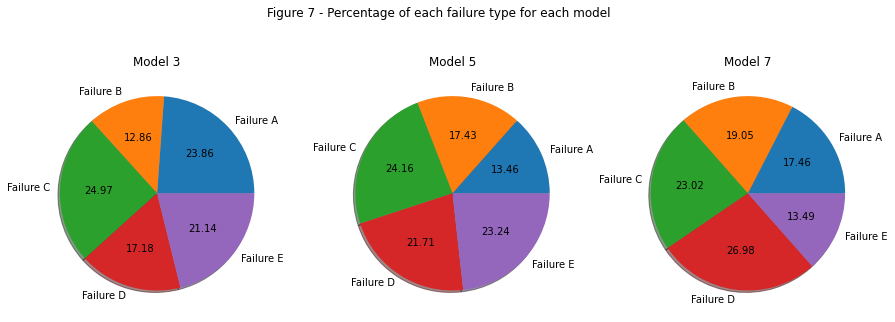

In [22]:
#Failure distribution
p_failA_model3 = df[(df['Failure A']==1) & (df['Model']=='Model 3')]['Car ID'].count()/Num_of_failed
p_failB_model3 = df[(df['Failure B']==1) & (df['Model']=='Model 3')]['Car ID'].count()/Num_of_failed
p_failC_model3 = df[(df['Failure C']==1) & (df['Model']=='Model 3')]['Car ID'].count()/Num_of_failed
p_failD_model3 = df[(df['Failure D']==1) & (df['Model']=='Model 3')]['Car ID'].count()/Num_of_failed
p_failE_model3 = df[(df['Failure E']==1) & (df['Model']=='Model 3')]['Car ID'].count()/Num_of_failed
print('Percentage of Model 3 with Failure A = {0:.2f}%'.format(p_failA_model3*100))
print('Percentage of Model 3 with Failure B = {0:.2f}%'.format(p_failB_model3*100))
print('Percentage of Model 3 with Failure C = {0:.2f}%'.format(p_failC_model3*100))
print('Percentage of Model 3 with Failure D = {0:.2f}%'.format(p_failD_model3*100))
print('Percentage of Model 3 with Failure E = {0:.2f}%'.format(p_failE_model3*100),'\n')

p_failA_model5 = df[(df['Failure A']==1) & (df['Model']=='Model 5')]['Car ID'].count()/Num_of_failed
p_failB_model5 = df[(df['Failure B']==1) & (df['Model']=='Model 5')]['Car ID'].count()/Num_of_failed
p_failC_model5 = df[(df['Failure C']==1) & (df['Model']=='Model 5')]['Car ID'].count()/Num_of_failed
p_failD_model5 = df[(df['Failure D']==1) & (df['Model']=='Model 5')]['Car ID'].count()/Num_of_failed
p_failE_model5 = df[(df['Failure E']==1) & (df['Model']=='Model 5')]['Car ID'].count()/Num_of_failed
print('Percentage of Model 5 with Failure A = {0:.2f}%'.format(p_failA_model5*100))
print('Percentage of Model 5 with Failure B = {0:.2f}%'.format(p_failB_model5*100))
print('Percentage of Model 5 with Failure C = {0:.2f}%'.format(p_failC_model5*100))
print('Percentage of Model 5 with Failure D = {0:.2f}%'.format(p_failD_model5*100))
print('Percentage of Model 5 with Failure E = {0:.2f}%'.format(p_failE_model5*100),'\n')

p_failA_model7 = df[(df['Failure A']==1) & (df['Model']=='Model 7')]['Car ID'].count()/Num_of_failed
p_failB_model7 = df[(df['Failure B']==1) & (df['Model']=='Model 7')]['Car ID'].count()/Num_of_failed
p_failC_model7 = df[(df['Failure C']==1) & (df['Model']=='Model 7')]['Car ID'].count()/Num_of_failed
p_failD_model7 = df[(df['Failure D']==1) & (df['Model']=='Model 7')]['Car ID'].count()/Num_of_failed
p_failE_model7 = df[(df['Failure E']==1) & (df['Model']=='Model 7')]['Car ID'].count()/Num_of_failed
print('Percentage of Model 7 with Failure A = {0:.2f}%'.format(p_failA_model7*100))
print('Percentage of Model 7 with Failure B = {0:.2f}%'.format(p_failB_model7*100))
print('Percentage of Model 7 with Failure C = {0:.2f}%'.format(p_failC_model7*100))
print('Percentage of Model 7 with Failure D = {0:.2f}%'.format(p_failD_model7*100))
print('Percentage of Model 7 with Failure E = {0:.2f}%'.format(p_failE_model7*100))

df_p3 = pd.DataFrame({'Percentage of Failure': [p_failA_model3, p_failB_model3, p_failC_model3, p_failD_model3, p_failE_model3]},
                  index=['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E'])
df_p5 = pd.DataFrame({'Percentage of Failure': [p_failA_model5, p_failB_model5, p_failC_model5, p_failD_model5, p_failE_model5]},
                  index=['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E'])
df_p7 = pd.DataFrame({'Percentage of Failure': [p_failA_model7, p_failB_model7, p_failC_model7, p_failD_model7, p_failE_model7]},
                  index=['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E'])
 
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
fig.subplots_adjust(top=0.8)
df_p3.plot.pie(y='Percentage of Failure', ax = axs[0], autopct='%.2f', shadow=True, ylabel='',legend=None)
df_p5.plot.pie(y='Percentage of Failure', ax = axs[1], autopct='%.2f', shadow=True, ylabel='',legend=None)
df_p7.plot.pie(y='Percentage of Failure', ax = axs[2], autopct='%.2f', shadow=True, ylabel='',legend=None)

axs[0].set_title('Model 3')
axs[1].set_title('Model 5')
axs[2].set_title('Model 7')
plt.suptitle('Figure 7 - Percentage of each failure type for each model')
plt.show()

#### Possible insight:
- Model 3 cars tend to suffer from Type A, C and E failures.
- Model 3 cars suffer the most type of failures among all three models.
- Model 5 cars tend to suffer from Type C, D and E failures.
- Model 7 cars tend to suffer from Type C, D failures.
- Cars without memberships constitute most of the failures.

## Observation 4 - Based on Figures 8 - 13

### Analysing the relationship between fuel consumption and failure type,

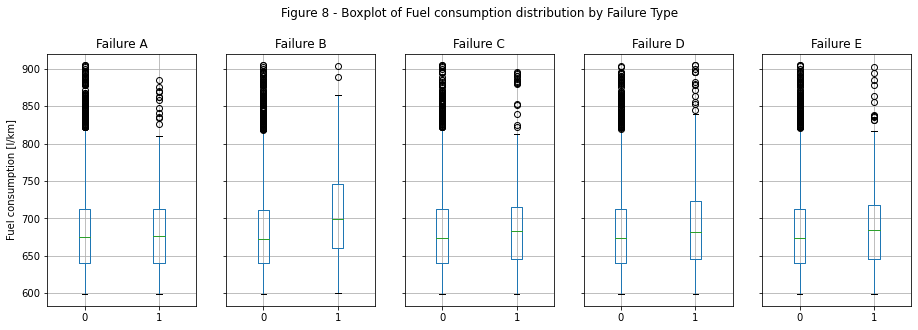

In [23]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=5, sharey='all')

df.boxplot(by='Failure A', column ='Fuel consumption', ax = axs[0])
df.boxplot(by='Failure B', column ='Fuel consumption', ax = axs[1])
df.boxplot(by='Failure C', column ='Fuel consumption', ax = axs[2])
df.boxplot(by='Failure D', column ='Fuel consumption', ax = axs[3])
df.boxplot(by='Failure E', column ='Fuel consumption', ax = axs[4])

axs[0].set_title('Failure A')
axs[0].set_xlabel('')
axs[0].set_ylabel('Fuel consumption [l/km]')
axs[1].set_title('Failure B')
axs[1].set_xlabel('')
axs[2].set_title('Failure C')
axs[2].set_xlabel('')
axs[3].set_title('Failure D')
axs[3].set_xlabel('')
axs[4].set_title('Failure E')
axs[4].set_xlabel('')
plt.suptitle('Figure 8 - Boxplot of Fuel consumption distribution by Failure Type')
fig.subplots_adjust(top=0.85)
plt.show()

#### Possible Insights:

- <b>Fuel consumption</b>: On average, most cars consume 650-700litres of petrol per km.

- <b>Fuel consumption</b>: Cars with above average fuel consumption tend to have Failure B.

### Analysing the relationship between temperature of car engine and failure type,

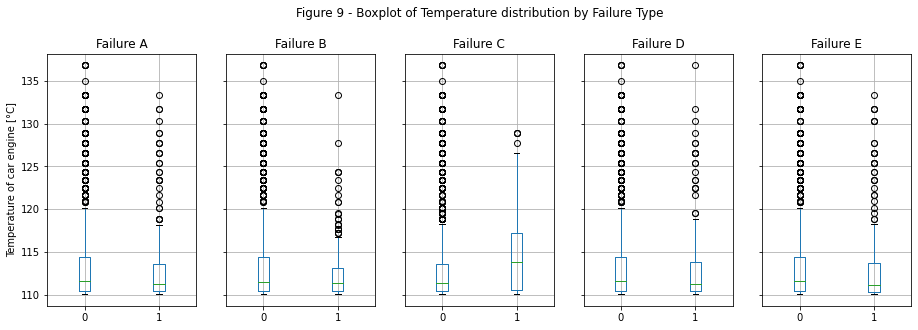

In [24]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=5, sharey='all')

df.boxplot(by='Failure A', column ='Temperature', ax = axs[0])
df.boxplot(by='Failure B', column ='Temperature', ax = axs[1])
df.boxplot(by='Failure C', column ='Temperature', ax = axs[2])
df.boxplot(by='Failure D', column ='Temperature', ax = axs[3])
df.boxplot(by='Failure E', column ='Temperature', ax = axs[4])

axs[0].set_title('Failure A')
axs[0].set_xlabel('')
axs[0].set_ylabel('Temperature of car engine [\u00b0C]')
axs[1].set_title('Failure B')
axs[1].set_xlabel('')
axs[2].set_title('Failure C')
axs[2].set_xlabel('')
axs[3].set_title('Failure D')
axs[3].set_xlabel('')
axs[4].set_title('Failure E')
axs[4].set_xlabel('')
plt.suptitle('Figure 9 - Boxplot of Temperature distribution by Failure Type')
fig.subplots_adjust(top=0.85)
plt.show()

#### Possible insight:

- <b>Temperature</b>: On average, an increment in temperature of car engine tends to indicate possible occurence of Failure C. Rise in engine temperature is usually due to cooling system leakage, faulty radiator fan, broken water pump, or clogged coolant hose.

### Analysing the relationship between RPM of car engine and failure type,

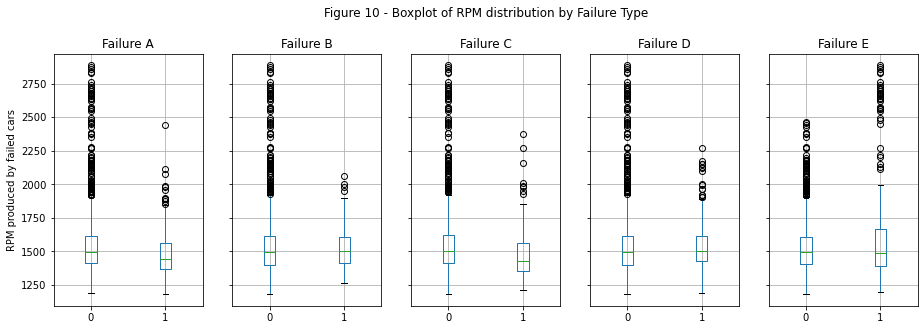

In [25]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=5, sharey='all')

df.boxplot(by='Failure A', column ='RPM', ax = axs[0])
df.boxplot(by='Failure B', column ='RPM', ax = axs[1])
df.boxplot(by='Failure C', column ='RPM', ax = axs[2])
df.boxplot(by='Failure D', column ='RPM', ax = axs[3])
df.boxplot(by='Failure E', column ='RPM', ax = axs[4])

axs[0].set_title('Failure A')
axs[0].set_xlabel('')
axs[0].set_ylabel('RPM produced by failed cars')
axs[1].set_title('Failure B')
axs[1].set_xlabel('')
axs[2].set_title('Failure C')
axs[2].set_xlabel('')
axs[3].set_title('Failure D')
axs[3].set_xlabel('')
axs[4].set_title('Failure E')
axs[4].set_xlabel('')
plt.suptitle('Figure 10 - Boxplot of RPM distribution by Failure Type')
fig.subplots_adjust(top=0.85)
plt.show()

#### Possible insight:
- <b>RPM</b>: On average, most cars are able to produce torque speed at 1500 rev per min.
- <b>RPM</b>: Cars detected with Failure A and C tend to produce low torque speed month before onset of failure.
- <b>RPM</b>: Cars detected with Failure E tend to be outliers that have high torque speed over the month before failure. It might be related to gearbox or brakes failures caused by over torquing.

### Analysing the relationship between year of production and failure type,

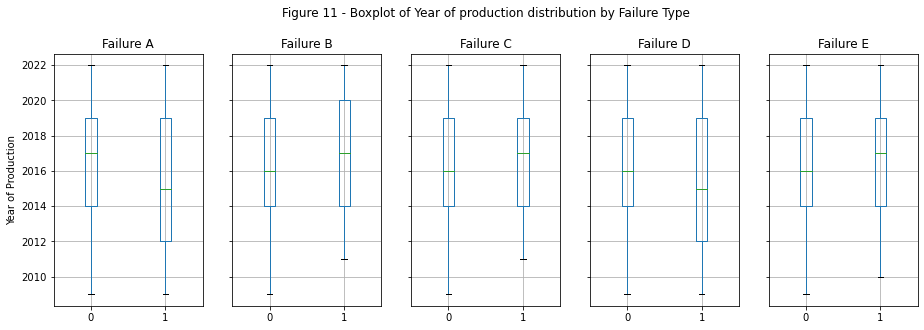

In [26]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=5, sharey='all')

df.boxplot(by='Failure A', column ='Year', ax = axs[0])
df.boxplot(by='Failure B', column ='Year', ax = axs[1])
df.boxplot(by='Failure C', column ='Year', ax = axs[2])
df.boxplot(by='Failure D', column ='Year', ax = axs[3])
df.boxplot(by='Failure E', column ='Year', ax = axs[4])

axs[0].set_title('Failure A')
axs[0].set_xlabel('')
axs[0].set_ylabel('Year of Production')
axs[1].set_title('Failure B')
axs[1].set_xlabel('')
axs[2].set_title('Failure C')
axs[2].set_xlabel('')
axs[3].set_title('Failure D')
axs[3].set_xlabel('')
axs[4].set_title('Failure E')
axs[4].set_xlabel('')
plt.suptitle('Figure 11 - Boxplot of Year of production distribution by Failure Type')
fig.subplots_adjust(top=0.85)
plt.show()

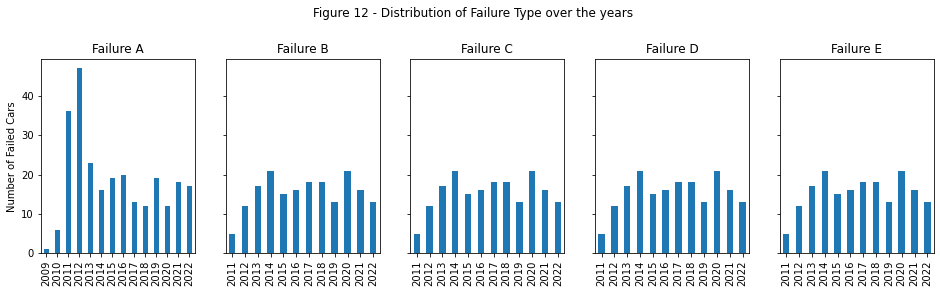

In [27]:
data3 = df[df['Failure A']==1]
data3 = data3[['Year','Car ID']]
data3 = data3.groupby(['Year'])[['Car ID']].nunique().reset_index()
data3 = data3.sort_values(by=['Year'], ascending = True)
index = list(data3['Year'].unique())
index.sort()
data3 = pd.DataFrame(list(data3['Car ID']), index=index)

data4 = df[df['Failure B']==1]
data4 = data4[['Year','Car ID']]
data4 = data4.groupby(['Year'])[['Car ID']].nunique().reset_index()
data4 = data4.sort_values(by=['Year'], ascending = True)
index = list(data4['Year'].unique())
index.sort()
data4 = pd.DataFrame(list(data4['Car ID']), index=index)

data5 = df[df['Failure B']==1]
data5 = data5[['Year','Car ID']]
data5 = data5.groupby(['Year'])[['Car ID']].nunique().reset_index()
data5 = data5.sort_values(by=['Year'], ascending = True)
index = list(data5['Year'].unique())
index.sort()
data5 = pd.DataFrame(list(data5['Car ID']), index=index)

data6 = df[df['Failure B']==1]
data6 = data6[['Year','Car ID']]
data6 = data6.groupby(['Year'])[['Car ID']].nunique().reset_index()
data6 = data6.sort_values(by=['Year'], ascending = True)
index = list(data6['Year'].unique())
index.sort()
data6 = pd.DataFrame(list(data6['Car ID']), index=index)

data7 = df[df['Failure B']==1]
data7 = data7[['Year','Car ID']]
data7 = data7.groupby(['Year'])[['Car ID']].nunique().reset_index()
data7 = data7.sort_values(by=['Year'], ascending = True)
index = list(data7['Year'].unique())
index.sort()
data7 = pd.DataFrame(list(data7['Car ID']), index=index)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=5, sharey='all')
data3.plot.bar(ax = axs[0],legend=None)
data4.plot.bar(ax = axs[1],legend=None)
data5.plot.bar(ax = axs[2],legend=None)
data6.plot.bar(ax = axs[3],legend=None)
data7.plot.bar(ax = axs[4],legend=None)

axs[0].set_title('Failure A')
axs[0].set_ylabel('Number of Failed Cars')
axs[1].set_title('Failure B')
axs[2].set_title('Failure C')
axs[3].set_title('Failure D')
axs[4].set_title('Failure E')
plt.suptitle('Figure 12 - Distribution of Failure Type over the years')
fig.subplots_adjust(top=0.8)
plt.show()

#### Possible insight:

- <b>Year of production</b>: Cars produced in earlier years of 2011, 2012 and 2013 tend to have higher numbers of Failure A. This might be due to some early design issue with the car that was later improved over the years by the company.
Cars produced after 2013 typically shows lower occurence of Type A failure.

## Analysing the relationship between Usage and failure,

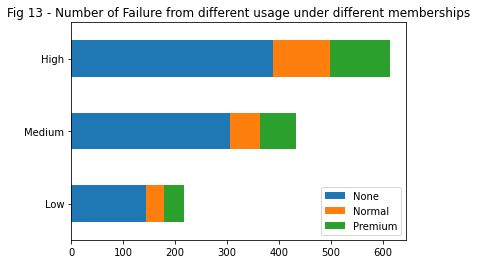

In [28]:
data2 = df[['Condition','Usage','Membership','Car ID']]
data2 = data2.groupby(['Condition','Usage','Membership'])[['Car ID']].count().reset_index()
data2 = data2[data2['Condition']==1].sort_values(by=['Car ID'], ascending = True)

index = list(data2['Usage'].unique())
data2 = pd.DataFrame({'None': list(data2[data2['Membership']=='None']['Car ID']),
                     'Normal': list(data2[data2['Membership']=='Normal']['Car ID']),
                     'Premium': list(data2[data2['Membership']=='Premium']['Car ID'])},index=index)

ax = data2.plot.barh(stacked=True)
ax.set(title="Fig 13 - Number of Failure from different usage under different memberships")
plt.show()

In [29]:
data2 = df[['Condition','Usage','Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E','Car ID']]
data2 = data2[data2['Condition']==1]
data2 = data2.groupby(['Usage'])[['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']].sum().reset_index()
data2

,Usage,Failure A,Failure B,Failure C,Failure D,Failure E
0,High,128,84,153,119,130
1,Low,41,35,60,38,42
2,Medium,90,66,97,87,92


#### Possible Insights

- Car with high usage tends to have more failure. This likely suggest that most failures are largely caused by wear and tear due to the lack of maintenance and upkeeping of the car condition.

## Conclusion
- Based on the above analysis, it seems that most of the cars with failure are the ones without any membership and with high usage rate. This suggest that the lack of car maintenance might be the cause because cars with 'Normal' or 'Premium' memberships are offered at two or unlimited complementary car servicing per year, respectively. 

#### Suggestion:
- To mitigate such occurence of car failure, the company should provide more incentives and perks in renewing and joining membership. 
- Company should include more incentives for joining the membership.
- Members or car owners who had sent their car back to the company for servicing can be rewarded with cashbacks or discount vouchers for petrol so as to encourage more car owners to upkeep their car condition - this is to reduce the company's warranty/repair expenses. 
- Car servicing reminders should also be sent out to car owners yearly.
- Sensors in the car should prompt the drivers for car servicing when the fuel consumption and temperature of car engine (113.42$^\circ$C and 684.83$l/km$, respectively) went above the average levels.
- Sensors should prompt car owners to check for Failure C when car produces low torque continuously over 30 days (below 1536.64rpm).
- Car produced in Year 2011, 2012 and 2013 should be recalled by the respectively factories for Failure A inspection checks.